In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from correlation_estimators import calculate_pearson
from sampling import pps, accept_reject
from scipy.stats.distributions import norm, expon

PROPERTY = 'fire_size'

dfo = pd.read_csv('./data/FW_Veg_Rem_Combined.csv')

cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]

def preprocess_missing_weather_data(df):
    df_subsample = df[df['Temp_pre_7'] == -1]
    df_clean = df[df['Temp_pre_7'] != -1]
    mean_weather_data = df_clean.groupby(['state', 'discovery_month'])[weather_columns].mean().reset_index()
    df_subsample.drop(weather_columns, axis=1, inplace=True)
    df_subsample = df_subsample.merge(mean_weather_data)
    df_clean = df_clean.append(df_subsample, ignore_index=True)
    return df_clean

df = preprocess_missing_weather_data(dfo)
df_full = df
df = pps(df, PROPERTY, 0.1)

df['fire_size'] = np.log(df['fire_size'])

df.shape[0]

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_22607/3321096114.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fire_size'] = np.log(df['fire_size'])


7835

In [12]:
#BAsesian network preparation

!git clone https://github.com/ITMO-NSS-team/BAMT.git
!pip install -r BAMT/requirements.txt

import os, sys

sys.path.append(os.path.join(os.path.dirname('./BAMT'), "BAMT"))

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

fatal: destination path 'BAMT' already exists and is not an empty directory.


In [13]:
bayesian_net_columns = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30', 'stat_cause_descr']
bayesian_net_columns_cont = ['remoteness', 'latitude', 'longitude', 'Temp_pre_7', 'Temp_pre_15', 'Temp_pre_30', 'Prec_pre_30', 'Hum_pre_7', 'Hum_pre_15', 'Hum_pre_30']
to_drop = filter(lambda col: col != PROPERTY and not col in bayesian_net_columns, df.columns)

df_bayes = df.drop(to_drop, axis=1)
df_bayes['stat_cause_descr'] = df_bayes['stat_cause_descr'].apply(lambda x: str(x))

for col in bayesian_net_columns_cont:
    df_bayes[col] = df_bayes[col].apply(lambda x: float(x))

df_bayes.dropna(inplace=True)
df_bayes.reset_index(inplace=True, drop=True)
df_bayes.head(10)

,fire_size,stat_cause_descr,latitude,longitude,Temp_pre_30,Temp_pre_15,Temp_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,remoteness
0,3.407179,Debris Burning,31.259000,-84.895600,20.079480,17.722714,18.188679,67.551783,61.733788,60.328571,0.0,0.162416
1,2.727853,Equipment Use,36.586500,-96.323220,8.523263,5.933658,2.911842,76.615217,80.177291,85.369369,150.8,0.263943
2,1.609438,Equipment Use,32.275940,-102.760900,6.224290,8.950698,8.880240,44.628895,32.515977,37.246939,0.0,0.327901
3,1.648659,Miscellaneous,33.426303,-84.925226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.161130
4,0.000000,Arson,40.746111,-75.748611,9.215850,9.625352,11.323707,66.972917,63.144681,65.285047,182.8,0.076025
5,2.302585,Arson,33.370210,-98.447810,8.372812,7.059375,8.493939,61.569249,71.109474,78.982301,86.5,0.285984
6,1.335001,Debris Burning,44.524631,-88.996043,0.578848,6.130116,7.645339,71.180254,68.552326,65.423729,40.2,0.192649
7,1.609438,Debris Burning,31.560615,-96.291583,10.410706,13.517045,11.311230,63.708520,63.083721,56.908108,22.7,0.266943
8,2.302585,Debris Burning,30.823796,-96.380568,28.834016,29.230492,29.885828,67.982322,65.747159,66.590818,0.0,0.268336
9,2.564949,Debris Burning,34.080486,-83.861637,6.950617,0.000000,0.000000,58.975309,0.000000,0.000000,0.0,0.151147


In [14]:
nodes_type = get_nodes_type(df_bayes)
nodes_sign = get_nodes_sign(df_bayes)

nodes_type
nodes_sign

{'fire_size': 'neg',
 'latitude': 'pos',
 'longitude': 'neg',
 'Temp_pre_30': 'neg',
 'Temp_pre_15': 'neg',
 'Temp_pre_7': 'neg',
 'Hum_pre_30': 'pos',
 'Hum_pre_15': 'pos',
 'Hum_pre_7': 'pos',
 'Prec_pre_30': 'pos',
 'remoteness': 'pos'}

In [15]:
coded_data, coder = code_categories(df_bayes, 'label', ['stat_cause_descr'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', bayesian_net_columns_cont)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [16]:
#bn_hc_k2 = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
#save_structure(bn_hc_k2, 'struct_bnhc_firesize_log')
#bn_hc_params = parameter_learning(discrete_data, nodes_type, bn_hc_k2, 'simple')
#save_params(bn_hc_params, 'params_bnhc_firesize_log')

bn_hc = read_structure('struct_bnhc_firesize_log')
bn_hc_params = read_params('params_bnhc_firesize_log')


bayes_hc = HyBayesianNetwork(bn_hc, bn_hc_params)

In [17]:
#bn_evo_k2 = structure_learning(discrete_data, 'evo', nodes_type)
#save_structure(bn_evo_k2, 'struct_evok2_firesize_log')
#bn_evo_params = parameter_learning(discrete_data, nodes_type, bn_evo_k2, 'simple')
#save_params(bn_evo_params, 'params_evok2_firesize_log')

bn_evo_k2 = read_structure('struct_evok2_firesize_log')
bn_evo_params = read_params('params_evok2_firesize_log')

bayes_evok2 = HyBayesianNetwork(bn_evo_k2, bn_evo_params)

In [19]:
bn_hc_mi = structure_learning(discrete_data, 'HC', nodes_type, 'MI')
save_structure(bn_hc_mi, 'struct_hcmi_firesize_log')
bn_hcmi_params = parameter_learning(discrete_data, nodes_type, bn_hc_mi, 'simple')
save_params(bn_hcmi_params, 'params_hcmi_firesize_log')

bn_hc_mi = read_structure('struct_hcmi_firesize_log')
bn_hcmi_params = read_params('params_hcmi_firesize_log')

bayes_hcmi = HyBayesianNetwork(bn_hc_mi, bn_hcmi_params)

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:224: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:236: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:182: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/BAMT/bayesian/redef_HC.py:156: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)


In [21]:
df_val = df_bayes.sample(frac=0.5)
df_val.shape[0]

3918

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


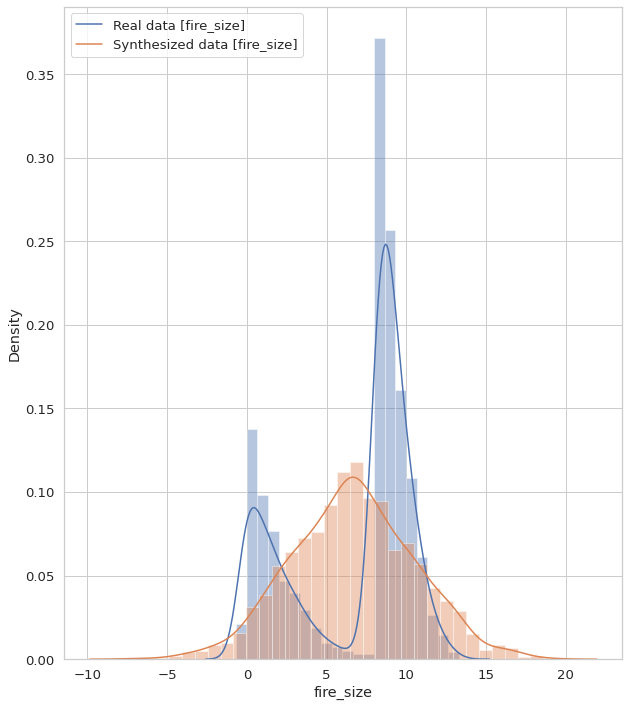

In [ ]:
#stats and predictions

answ_hc =  calculate_acc(bayes_hc, df_val, ['fire_size'], 'simple')

synth_data_hc = generate_synthetics(bayes_hc, nodes_sign, 'simple', 2000)

print(f'RMDS is {answ_hc[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_hc['fire_size'], ax=ax)
ax.legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()

In [22]:
answ_hcmi =  calculate_acc(bayes_hcmi, df_val, ['fire_size'], 'simple')

synth_data_hcmi = generate_synthetics(bayes_hcmi, nodes_sign, 'simple', 1200)

print(f'RMDS is {answ_hcmi[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_hcmi['fire_size'], ax=ax)
ax.legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()

0
"['Lightning']"
1
"['Powerline']"
2
"['Lightning']"
3
"['Arson']"
4
"['Lightning']"
5
"['Equipment Use']"
6
"['Lightning']"
7
"['Campfire']"
8
"['Missing/Undefined']"
9
"['Equipment Use']"
10
"['Miscellaneous']"
11
"['Lightning']"
12
"['Lightning']"
13
"['Miscellaneous']"
14
"['Debris Burning']"
15
"['Lightning']"
16
"['Arson']"
17
"['Lightning']"
18
"['Debris Burning']"
19
"['Miscellaneous']"
20
"['Lightning']"
21
"['Debris Burning']"
22
"['Miscellaneous']"
23
"['Lightning']"
24
"['Miscellaneous']"
25
"['Lightning']"
26
"['Missing/Undefined']"
27
"['Debris Burning']"
28
"['Arson']"
29
"['Debris Burning']"
30
"['Miscellaneous']"
31
"['Debris Burning']"
32
"['Lightning']"
33
"['Equipment Use']"
34
"['Arson']"
35
"['Arson']"
36
"['Equipment Use']"
37
"['Arson']"
38
"['Arson']"
39
"['Lightning']"
40
"['Lightning']"
41
"['Equipment Use']"
42
"['Lightning']"
43
"['Powerline']"
44
"['Debris Burning']"
45
"['Lightning']"
46
"['Arson']"
47
"['Lightning']"
48
"['Debris Burning']"
49
"['Lightn

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/task3/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


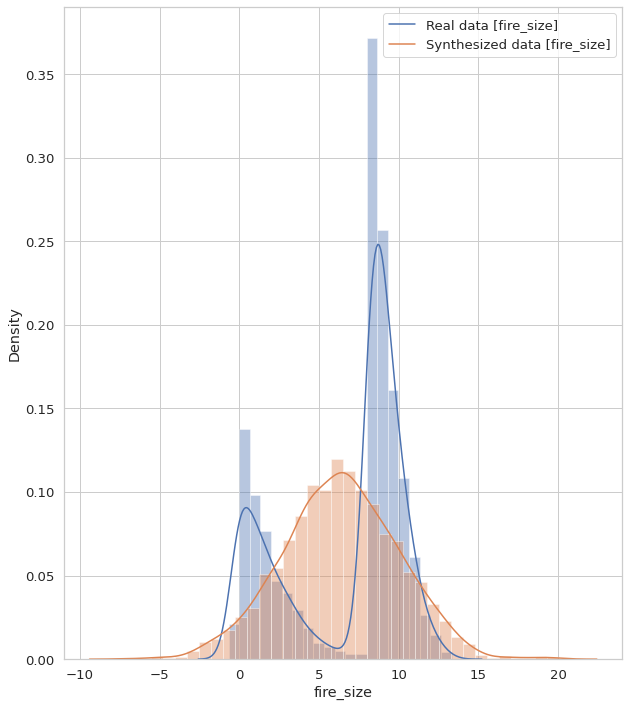

In [23]:

answ_evok2 =  calculate_acc(bayes_evok2, df_val, ['fire_size'], 'simple')

synth_data_evok2 = generate_synthetics(bayes_evok2, nodes_sign, 'simple', 2000)

print(f'RMDS is {answ_evok2[1]}')

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(1, 1, figsize=(10, 12))

sns.distplot(df_bayes['fire_size'], ax=ax)
sns.distplot(synth_data_evok2['fire_size'], ax=ax)
ax.legend(['Real data [fire_size]', 'Synthesized data [fire_size]'])
plt.show()